In [3]:
# Setup cell - run this first
import subprocess
import sys

# List of required packages
required_packages = [
    'nltk',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'nest_asyncio',
    # Add other packages as needed
]

# Install missing packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)

print("✓ All packages installed and ready!")

Installing nltk...
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
✓ All packages installed and ready!


In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import asyncio
import nest_asyncio

# Enable async in Jupyter
nest_asyncio.apply()

# Add project root to path
sys.path.append('..')

# Import our modules
from core.config import (
    ConfigManager,  # <-- This was missing
    RAGConfig, MetricsConfig, 
    LoaderConfig, ChunkerConfig, EmbeddingConfig,
    RetrievalConfig, GenerationConfig
)
from system.rag_system import ModularRAGSystem
from system.experiment_runner import ExperimentRunner
from analysis.results import ResultsAnalyzer
from utils import create_project_directories, verify_api_keys

# Setup directories
dirs = create_project_directories()
print("Project directories created")

# Verify API keys
api_status = verify_api_keys()
if not api_status.get("OPENAI_API_KEY"):
    print("Please set your OPENAI_API_KEY environment variable")
else:
    print("API keys verified")

Created documents directory: ./documents
Created data directory: ./data
Created configs directory: ./configs
Created results directory: ./results
Created logs directory: ./logs
Project directories created
OPENAI_API_KEY is configured
ANTHROPIC_API_KEY is not set
API keys verified


In [2]:
# Load your test questions from the spreadsheet
# Update this path to match your actual file location
questions_file = "./data/ab_testing_questions.xlsx"  # Update this path

# Read the Excel file
try:
    questions_df = pd.read_excel(questions_file)
    print(f"Loaded {len(questions_df)} questions from spreadsheet")
except FileNotFoundError:
    print(f"Could not find {questions_file}")
    print("Please update the path to your Excel file")
    # For demonstration, let's parse a few from your provided data
    questions_data = [
        {
            "Category": "Data Preparation",
            "Example Question": "What should I do if my file size exceeds the 4GB limit?",
            "Solution Type": "Diagnostic",
            "Follow Up Question": "How should I sample new data without biasing results?",
            "Follow Up Solution Type": "Procedural"
        },
        {
            "Category": "Data Preparation", 
            "Example Question": "What is the variant assignment column, and why is it important?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "Some variant assignments are null; how does this impact my current experiment?",
            "Follow Up Solution Type": "Diagnostic"
        },
        {
            "Category": "Experimental Design",
            "Example Question": "What is Type I error (α), and how does it affect my experiment?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "What effect does my chosen alpha (0.05) have on false positives here?",
            "Follow Up Solution Type": "Clarifying"
        },
        {
            "Category": "Assumption Checking",
            "Example Question": "If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?",
            "Solution Type": "Diagnostic",
            "Follow Up Question": "What if Q-Q plots deviate from diagonal in my revenue data?",
            "Follow Up Solution Type": "Diagnostic"
        },
        {
            "Category": "CUPED Adjustment",
            "Example Question": "What is CUPED and how does it improve my experiment analysis?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "How can I validate that CUPED adjustment improved sensitivity in my current dataset?",
            "Follow Up Solution Type": "Diagnostic"
        }
    ]
    questions_df = pd.DataFrame(questions_data)

# Display question statistics
print("\nQuestion Distribution:")
print(questions_df['Category'].value_counts())
print("\nSolution Type Distribution:")
print(questions_df['Solution Type'].value_counts())

# Prepare questions for testing
test_questions = []
for idx, row in questions_df.iterrows():
    # Main question
    test_questions.append({
        "id": f"q_{idx}_main",
        "question": row['Example Question'],
        "category": row['Category'].lower().replace(' ', '_'),
        "solution_type": row['Solution Type'].lower(),
        "is_follow_up": False
    })
    
    # Follow-up question if exists
    if pd.notna(row.get('Follow Up Question')):
        test_questions.append({
            "id": f"q_{idx}_followup",
            "question": row['Follow Up Question'],
            "category": row['Category'].lower().replace(' ', '_'),
            "solution_type": row.get('Follow Up Solution Type', 'clarifying').lower(),
            "is_follow_up": True
        })

print(f"\n✓ Prepared {len(test_questions)} test questions (including follow-ups)")

Could not find ./data/ab_testing_questions.xlsx
Please update the path to your Excel file

Question Distribution:
Category
Data Preparation       2
Experimental Design    1
Assumption Checking    1
CUPED Adjustment       1
Name: count, dtype: int64

Solution Type Distribution:
Solution Type
Clarifying    3
Diagnostic    2
Name: count, dtype: int64

✓ Prepared 10 test questions (including follow-ups)


In [3]:
# Path to your knowledge base PDF
# Update this to match your actual PDF location
knowledge_base_path = "./documents"  # Update if your PDF is elsewhere
pdf_file = "kb.pdf"  # Update with your actual PDF filename

# Check if PDF exists
pdf_path = Path(knowledge_base_path) / pdf_file
if not pdf_path.exists():
    print(f"PDF not found at {pdf_path}")
    print("Please update the path to your knowledge base PDF")
    print("\nLooking for PDFs in documents folder...")
    pdf_files = list(Path(knowledge_base_path).glob("*.pdf"))
    if pdf_files:
        print("Found PDFs:")
        for i, pdf in enumerate(pdf_files):
            print(f"  {i+1}. {pdf.name}")
        # Use the first PDF found
        pdf_path = pdf_files[0]
        print(f"\nUsing: {pdf_path}")
else:
    print(f"Found knowledge base PDF: {pdf_path}")

Found knowledge base PDF: documents/kb.pdf


In [4]:
import sys
print(sys.executable)
print(sys.prefix)

/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/bin/python
/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline


2025-07-30 13:51:48,656 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 13:51:48,661 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 13:51:48,708 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 13:51:48,709 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 13:51:48,709 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 13:51:48,727 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
RAG system initialized
2025-07-30 13:51:48,728 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 13:51:53,173 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 13:51:53,193 - document_processing.processor - INFO - Created 1645 chunks with recursive strategy


### Chunking Summary

Created 1645 chunks from 224 documents
Average chunk size: 341 characters


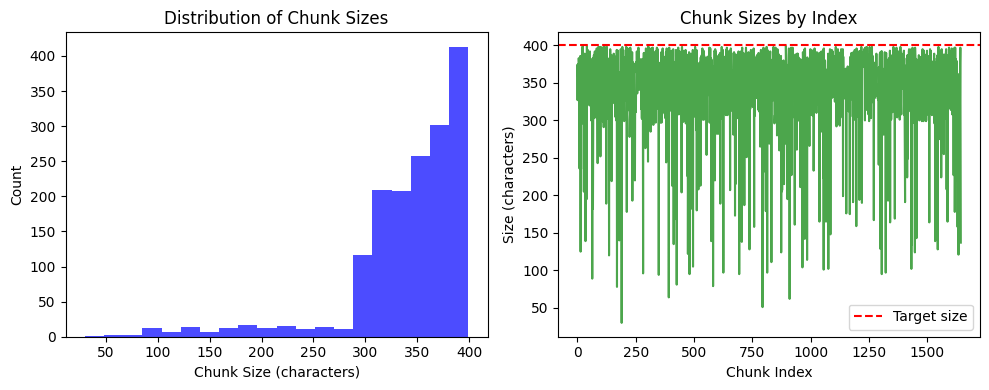


Chunk size statistics:
  Min: 30 chars
  Max: 399 chars
  Mean: 341 chars
  Target: 400 chars
Processed 1645 chunks from PDF

Sample chunks from your knowledge base:

Chunk 1:
Content: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: ...
Source: documents/kb.pdf
Page: 0

Chunk 2:
Content: can obtain the desired power of the experiment. 
Statistical Concept: We follow the "static test" design approach. 
In A/B testing, a static test mean...
Source: documents/kb.pdf
Page: 0

Chunk 3:
Content:  We run the experiment to completion based on that sample size. 
That’s why we need the sample size calculator: To figure out what number to predefin...
Source: documents/kb.pdf
Page: 0


## Vector Store Management

### Creating FAISS Vector Store

Processing 1645 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully

Vector store created


## Building RAG Pipeline

2025-07-30 13:52:00,327 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 13:52:00,329 - factories.retriever - ERROR - Error creating hybrid retriever: Could not import rank_bm25, please install with `pip install rank_bm25`.


ImportError: Could not import rank_bm25, please install with `pip install rank_bm25`.

In [15]:
# Create configuration optimized for A/B testing Q&A
base_config = RAGConfig(
    experiment_name="ab_testing_qa_evaluation",
    experiment_id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    
    # Document processing - for PDF
    loader=LoaderConfig(type="pdf"),
    
    # Chunking strategy optimized for technical Q&A
    chunker=ChunkerConfig(
        method="recursive",
        chunk_size=400,  # Smaller chunks for precise answers
        chunk_overlap=100  # Good overlap for context
    ),
    
    # Embeddings
    embedding=EmbeddingConfig(
        provider="openai",
        model="text-embedding-3-small"
    ),
    
    # Retrieval - hybrid for best results
    retrieval=RetrievalConfig(
        strategy="hybrid",
        top_k=7  # More contexts for comprehensive answers
    ),
    
    # Generation
    generation=GenerationConfig(
        provider="openai",
        model="gpt-4o-mini",
        temperature=0.1,  # Low for consistency
        max_tokens=800
    ),
    
    # Comprehensive evaluation metrics
    metrics=MetricsConfig(
        metric_names=[
            # RAGAS metrics
            "ragas_faithfulness",
            "ragas_answer_relevancy",
            # CoFE-RAG metrics
            "cofe_retrieval_recall",
            "cofe_retrieval_accuracy", 
            "cofe_generation_faithfulness",
            "cofe_generation_relevance",
            "cofe_pipeline_score",
            # OmniEval metrics
            "omni_accuracy",
            "omni_completeness",
            "omni_hallucination",
            "omni_utilization",
            "omni_weighted_score",
            # General
            "response_time",
            "aggregate_score"
        ]
    )
)

# Initialize system
config_manager = ConfigManager(base_config)
rag_system = ModularRAGSystem(config_manager)
rag_system.initialize_components()
print("RAG system initialized")

# Load and process the PDF
chunks = rag_system.load_and_process_documents(str(pdf_path.parent))
print(f"Processed {len(chunks)} chunks from PDF")

# Show sample chunks to verify loading
print("\nSample chunks from your knowledge base:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\nChunk {i+1}:")
    print(f"Content: {chunk.page_content[:150]}...")
    print(f"Source: {chunk.metadata.get('source', 'Unknown')}")
    print(f"Page: {chunk.metadata.get('page', 'N/A')}")

# Create vector store
vector_store = rag_system.create_or_load_vector_store(chunks, force_rebuild=True)
print("\nVector store created")

# Build pipeline
pipeline = rag_system.build_pipeline()
print("Pipeline built - ready for testing!")

In [ ]:
# Test questions by category
categories = list(set(q['category'] for q in test_questions))

print("Testing Questions by Category:")
print("="*80)

category_results = {}

for category in categories[:5]:  # Test first 5 categories
    print(f"\n\nCATEGORY: {category.upper().replace('_', ' ')}")
    print("-"*60)
    
    # Get questions for this category
    cat_questions = [q for q in test_questions if q['category'] == category][:2]  # Max 2 per category
    
    category_scores = []
    
    for q in cat_questions:
        print(f"\nQuestion: {q['question']}")
        print(f"Type: {q['solution_type']} | Follow-up: {q['is_follow_up']}")
        
        # Run query
        result = await rag_system.query(
            question=q['question'],
            evaluate=True
        )
        
        print(f"\nAnswer:\n{result['answer'][:300]}...")  # Show first 300 chars
        
        # Store scores
        if 'evaluation' in result:
            eval_scores = result['evaluation']
            scores = {
                'faithfulness': eval_scores.get('ragas_faithfulness', 0),
                'relevancy': eval_scores.get('ragas_answer_relevancy', 0),
                'pipeline': eval_scores.get('cofe_pipeline_score', 0),
                'omni_score': eval_scores.get('omni_weighted_score', 0),
                'aggregate': eval_scores.get('aggregate_score', 0)
            }
            category_scores.append(scores)
            
            print(f"\nScores:")
            print(f"  Aggregate: {scores['aggregate']:.3f}")
            print(f"  Faithfulness: {scores['faithfulness']:.3f}")
            print(f"  Pipeline: {scores['pipeline']:.3f}")
    
    # Calculate category average
    if category_scores:
        avg_scores = {k: np.mean([s[k] for s in category_scores]) for k in category_scores[0].keys()}
        category_results[category] = avg_scores
        print(f"\nCategory Average Scores:")
        for metric, score in avg_scores.items():
            print(f"  {metric}: {score:.3f}")

In [ ]:
# Analyze performance by solution type
print("\n\nTesting by Solution Type:")
print("="*80)

solution_types = list(set(q['solution_type'] for q in test_questions))
solution_results = {}

for sol_type in solution_types:
    print(f"\n\nSOLUTION TYPE: {sol_type.upper()}")
    print("-"*60)
    
    # Get sample questions
    type_questions = [q for q in test_questions if q['solution_type'] == sol_type][:3]
    
    type_scores = []
    
    for q in type_questions:
        print(f"\nQ: {q['question'][:100]}...")
        
        result = await rag_system.query(q['question'], evaluate=True)
        
        if 'evaluation' in result:
            scores = {
                'aggregate': result['evaluation'].get('aggregate_score', 0),
                'accuracy': result['evaluation'].get('omni_accuracy', 0),
                'completeness': result['evaluation'].get('omni_completeness', 0),
                'response_time': result['response_time']
            }
            type_scores.append(scores)
            print(f"  Score: {scores['aggregate']:.3f} | Time: {scores['response_time']:.2f}s")
    
    # Average for this type
    if type_scores:
        avg_scores = {k: np.mean([s[k] for s in type_scores]) for k in type_scores[0].keys()}
        solution_results[sol_type] = avg_scores
        print(f"\nAverage for {sol_type}:")
        print(f"  Score: {avg_scores['aggregate']:.3f}")
        print(f"  Response Time: {avg_scores['response_time']:.2f}s")

In [ ]:
# Define configuration variants for A/B testing
ab_test_variants = {
    # Chunking strategies
    "chunker.method": ["recursive", "semantic", "sentence"],
    "chunker.chunk_size": [300, 400, 600],
    
    # Retrieval strategies
    "retrieval.strategy": ["vector", "hybrid", "bm25"],
    "retrieval.top_k": [5, 7, 10],
    
    # Generation parameters
    "generation.temperature": [0.0, 0.1, 0.3],
    "generation.model": ["gpt-4o-mini", "gpt-4"]  # Remove if you don't have GPT-4 access
}

# For quick testing, use a subset
quick_variants = {
    "chunker.method": ["recursive", "semantic"],
    "chunker.chunk_size": [400, 600],
    "retrieval.strategy": ["vector", "hybrid"],
    "retrieval.top_k": [5, 7]
}

# Select representative questions for A/B testing
ab_test_questions = []
for category in categories[:5]:  # Use 5 categories
    cat_q = [q for q in test_questions if q['category'] == category][:2]  # 2 questions per category
    ab_test_questions.extend(cat_q)

print(f"Running A/B test with:")
print(f"  - {len(ab_test_questions)} test questions")
print(f"  - Testing variants: {quick_variants}")

# Initialize experiment runner
runner = ExperimentRunner(base_path="./experiments/ab_testing_qa")

# Run A/B test
results_df = await runner.run_ab_test(
    base_config=base_config,
    variants=quick_variants,
    test_questions=[{"question": q["question"], 
                    "category": q["category"],
                    "solution_type": q["solution_type"]} 
                   for q in ab_test_questions],
    document_path=str(pdf_path.parent)
)

print(f"\n✓ A/B test completed!")
print(f"Total evaluations: {len(results_df)}")

In [ ]:
# Analyze A/B test results
analyzer = ResultsAnalyzer(results_df)

# Get best configuration
best_config = analyzer.get_best_configuration()

print("="*80)
print("A/B TESTING RESULTS ANALYSIS")
print("="*80)

print(f"\n🏆 BEST CONFIGURATION:")
print(f"Configuration: {best_config['configuration']}")
print(f"Average Score: {best_config['mean_score']:.3f} (±{best_config['std']:.3f})")
print(f"\nDetails:")
for key, value in best_config['details'].items():
    print(f"  {key}: {value}")

# Analyze by component
print("\n\nCOMPONENT ANALYSIS:")
print("-"*60)
component_analysis = analyzer.analyze_by_component()

for component, analysis in component_analysis.items():
    print(f"\n{component.upper()}:")
    print(analysis.head())
    best_value = analysis['mean'].idxmax()
    print(f"  → Best: {best_value} (score: {analysis.loc[best_value, 'mean']:.3f})")

# Category-specific performance
if 'category' in results_df.columns:
    print("\n\nPERFORMANCE BY CATEGORY:")
    print("-"*60)
    cat_performance = results_df.groupby(['category', 'config_description'])['aggregate_score'].mean()
    
    for category in results_df['category'].unique():
        cat_data = cat_performance[category]
        best_cat_config = cat_data.idxmax()
        print(f"\n{category.upper()}:")
        print(f"  Best Config: {best_cat_config}")
        print(f"  Score: {cat_data.max():.3f}")

In [ ]:
# Create visualizations
analyzer.create_performance_dashboard()

# Additional custom visualizations
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Category Performance Heatmap
ax1 = axes[0, 0]
if 'category' in results_df.columns:
    cat_pivot = results_df.pivot_table(
        values='aggregate_score',
        index='config_description',
        columns='category',
        aggfunc='mean'
    )
    sns.heatmap(cat_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Performance Heatmap by Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Configuration')

# 2. Solution Type Performance
ax2 = axes[0, 1]
if 'solution_type' in results_df.columns:
    sol_type_scores = results_df.groupby('solution_type')['aggregate_score'].mean().sort_values()
    sol_type_scores.plot(kind='barh', ax=ax2, color='skyblue')
    ax2.set_title('Average Performance by Solution Type')
    ax2.set_xlabel('Aggregate Score')

# 3. Response Time Distribution
ax3 = axes[1, 0]
results_df.boxplot(column='response_time', by='config_description', ax=ax3, rot=90)
ax3.set_title('Response Time Distribution by Configuration')
ax3.set_ylabel('Response Time (seconds)')

# 4. Evaluation Framework Comparison
ax4 = axes[1, 1]
framework_cols = {
    'RAGAS': ['ragas_faithfulness', 'ragas_answer_relevancy'],
    'CoFE-RAG': ['cofe_pipeline_score'],
    'OmniEval': ['omni_weighted_score']
}
framework_means = {}
for name, cols in framework_cols.items():
    available = [c for c in cols if c in results_df.columns]
    if available:
        framework_means[name] = results_df[available].mean().mean()

if framework_means:
    pd.Series(framework_means).plot(kind='bar', ax=ax4, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax4.set_title('Average Scores by Evaluation Framework')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./experiments/ab_testing_qa_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Function for testing custom questions
async def test_ab_question(question: str, show_contexts: bool = False):
    """Test any A/B testing question and see detailed results"""
    print("\n" + "="*80)
    print(f"Question: {question}")
    print("="*80)
    
    # Get answer
    result = await rag_system.query(question, evaluate=True)
    
    print(f"\n📝 ANSWER:")
    print("-"*40)
    print(result['answer'])
    
    # Show contexts if requested
    if show_contexts and 'contexts' in result:
        print(f"\n📚 RETRIEVED CONTEXTS ({len(result['contexts'])}):")
        print("-"*40)
        for i, ctx in enumerate(result['contexts'][:3]):  # Show first 3
            print(f"\nContext {i+1}:")
            print(ctx[:200] + "...")
    
    # Show evaluation scores
    if 'evaluation' in result:
        eval_scores = result['evaluation']
        print(f"\n📊 EVALUATION SCORES:")
        print("-"*40)
        print(f"Aggregate Score: {eval_scores.get('aggregate_score', 0):.3f}")
        print(f"RAGAS Faithfulness: {eval_scores.get('ragas_faithfulness', 0):.3f}")
        print(f"CoFE Pipeline: {eval_scores.get('cofe_pipeline_score', 0):.3f}")
        print(f"OmniEval Score: {eval_scores.get('omni_weighted_score', 0):.3f}")
        print(f"Response Time: {result['response_time']:.2f}s")
    
    return result

# Test some real-world A/B testing questions
test_scenarios = [
    "My p-value is 0.06 but my boss wants to launch. What should I do?",
    "How do I know if my sample size is large enough for detecting a 2% uplift?",
    "The treatment group has 20% fewer users than control. Is my test valid?",
    "Should I use CUPED if my pre-experiment metric has correlation of 0.25?",
    "What's the difference between statistical and practical significance?"
]

print("Testing Real-World A/B Testing Scenarios:")
for scenario in test_scenarios[:3]:  # Test first 3
    await test_ab_question(scenario, show_contexts=False)

In [ ]:
# Generate comprehensive report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f"./experiments/ab_testing_qa_report_{timestamp}.md"

with open(report_path, 'w') as f:
    f.write("# A/B Testing Q&A System Evaluation Report\n\n")
    f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Executive Summary
    f.write("## Executive Summary\n\n")
    f.write(f"- **Knowledge Base:** {pdf_path.name}\n")
    f.write(f"- **Test Questions:** {len(test_questions)} questions from spreadsheet\n")
    f.write(f"- **Configurations Tested:** {results_df['config_description'].nunique()}\n")
    f.write(f"- **Best Configuration:** `{best_config['configuration']}`\n")
    f.write(f"- **Best Score:** {best_config['mean_score']:.3f}\n\n")
    
    # Configuration Details
    f.write("## Optimal Configuration\n\n")
    f.write("```yaml\n")
    f.write(f"chunking:\n")
    f.write(f"  method: {best_config['details']['chunker_method']}\n")
    f.write(f"  size: {best_config['details']['chunk_size']}\n")
    f.write(f"retrieval:\n")
    f.write(f"  strategy: {best_config['details']['retriever_strategy']}\n")
    f.write(f"  top_k: {best_config['details']['top_k']}\n")
    f.write(f"generation:\n")
    f.write(f"  model: {best_config['details']['generator_model']}\n")
    f.write("```\n\n")
    
    # Performance by Category
    f.write("## Performance by Question Category\n\n")
    if category_results:
        f.write("| Category | Aggregate Score | Faithfulness | Pipeline Score |\n")
        f.write("|----------|----------------|--------------|----------------|\n")
        for cat, scores in category_results.items():
            f.write(f"| {cat.replace('_', ' ').title()} | {scores['aggregate']:.3f} | "
                   f"{scores['faithfulness']:.3f} | {scores['pipeline']:.3f} |\n")
    
    # Performance by Solution Type
    f.write("\n## Performance by Solution Type\n\n")
    if solution_results:
        f.write("| Solution Type | Avg Score | Avg Response Time |\n")
        f.write("|--------------|-----------|------------------|\n")
        for sol_type, scores in solution_results.items():
            f.write(f"| {sol_type.title()} | {scores['aggregate']:.3f} | "
                   f"{scores['response_time']:.2f}s |\n")
    
    # Key Insights
    f.write("\n## Key Insights\n\n")
    f.write("1. **Best Performing Categories:**\n")
    if category_results:
        sorted_cats = sorted(category_results.items(), key=lambda x: x[1]['aggregate'], reverse=True)
        for i, (cat, scores) in enumerate(sorted_cats[:3]):
            f.write(f"   - {cat.replace('_', ' ').title()}: {scores['aggregate']:.3f}\n")
    
    f.write("\n2. **Configuration Recommendations:**\n")
    f.write(f"   - Chunking: Use `{best_config['details']['chunker_method']}` ")
    f.write(f"with size `{best_config['details']['chunk_size']}`\n")
    f.write(f"   - Retrieval: `{best_config['details']['retriever_strategy']}` ")
    f.write(f"with `{best_config['details']['top_k']}` contexts\n")
    
    f.write("\n3. **Performance Characteristics:**\n")
    f.write(f"   - Average response time: {results_df['response_time'].mean():.2f}s\n")
    f.write(f"   - RAGAS Faithfulness: {results_df['ragas_faithfulness'].mean():.3f}\n")
    f.write(f"   - CoFE Pipeline Score: {results_df['cofe_pipeline_score'].mean():.3f}\n")
    
    # Recommendations
    f.write("\n## Recommendations\n\n")
    f.write("1. **Deploy** the optimal configuration for production use\n")
    f.write("2. **Monitor** performance on real user questions\n")
    f.write("3. **Update** the knowledge base PDF regularly with new A/B testing scenarios\n")
    f.write("4. **Collect** user feedback on answer quality and completeness\n")
    f.write("5. **Re-evaluate** monthly with new questions from actual usage\n")

print(f"✓ Report saved to: {report_path}")

# Also export detailed results
analyzer.export_results(f"./experiments/ab_testing_qa_results_{timestamp}.xlsx")
print(f"✓ Detailed Excel analysis exported")

# Quick stats summary
print("\n" + "="*60)
print("EVALUATION COMPLETE - QUICK STATS")
print("="*60)
print(f"Knowledge Base: {pdf_path.name}")
print(f"Questions Tested: {len(test_questions)}")
print(f"Best Score: {best_config['mean_score']:.3f}")
print(f"Avg Response Time: {results_df['response_time'].mean():.2f}s")
print(f"Best Chunking: {best_config['details']['chunker_method']}")
print(f"Best Retrieval: {best_config['details']['retriever_strategy']}")